In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Sun Jun 12 18:14:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   39C    P8    21W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 29%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_de = db.patent_de
    # db_us = db.patent_us
    # db_cn = db.patent_cn

    db_rm_cn_2017 = db.rm_patent_cn_2017
    db_rm_us_2017 = db.rm_patent_us_2017
    db_rm_de_2017 = db.rm_patent_de_2017

    
except errors.ConnectionFailure as err:
    print(err)

# 2017

## Company數量

In [6]:
data_assignee = db_rm_de_2017.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [7]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [8]:
data_assignee = db_rm_cn_2017.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
data_assignee = db_rm_us_2017.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

In [11]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
58,Samsung Electronics Co Ltd,678
54,Qualcomm Inc,655
61,Shenzhen Shenglu IoT Communication Technology ...,622
38,Intel Corp,403
68,Telefonaktiebolaget LM Ericsson AB,395
36,Huawei Technologies Co Ltd,291
40,International Business Machines Corp,247
73,Xian Irain IoT Technology Service Co Ltd,139
16,Cisco Technology Inc,130
47,NTT Docomo Inc,125


In [12]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df.reset_index(drop=True, inplace=True)

In [13]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,Samsung Electronics Co Ltd,678,6.519147
1,Qualcomm Inc,655,6.484635
2,Shenzhen Shenglu IoT Communication Technology ...,622,6.432940
3,Intel Corp,403,5.998937
4,Telefonaktiebolaget LM Ericsson AB,395,5.978886
5,Huawei Technologies Co Ltd,291,5.673323
6,International Business Machines Corp,247,5.509388
7,Xian Irain IoT Technology Service Co Ltd,139,4.934474
8,Cisco Technology Inc,130,4.867534
9,NTT Docomo Inc,125,4.828314


In [14]:
com_ls = list(com_df.company)

## Data

In [15]:
ccontry = pd.read_csv("./final_data/rm_company_country_all_2017.csv")
ccpc = pd.read_csv("./final_data/rm_company_cpc_all_2017.csv")

In [16]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AR,AT,AU,BE,BR,CA,CH,CL,CN,...,PT,RS,RU,SE,SG,SI,TR,TW,US,ZA
399,Chengdu Qinchuan IoT Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
430,China Mobile Communications Group Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
493,Cisco Technology Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133.0,0.0
1004,Hangzhou Wopu IoT Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1106,Huawei Technologies Co Ltd,1.0,0.0,11.0,0.0,41.0,13.0,0.0,0.0,287.0,...,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,155.0,1.0


## Similarity計算

### Country

- 換成機率  

In [17]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [18]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AR,AT,AU,BE,BR,CA,CH,CL,CN,CO,...,PT,RS,RU,SE,SG,SI,TR,TW,US,ZA
company,,,,,,,,,,,,,,,,,,,,,
Samsung Electronics Co Ltd,0.000000,0.0,0.007867,0.0,0.000463,0.000925,0.0,0.000000,0.204072,0.000000,...,0.000463,0.0,0.001388,0.0,0.000925,0.000000,0.0,0.003239,0.304026,0.000000
Qualcomm Inc,0.000795,0.0,0.040954,0.0,0.077137,0.040159,0.0,0.000795,0.193638,0.000795,...,0.000000,0.0,0.001988,0.0,0.018290,0.000795,0.0,0.062823,0.257654,0.000398
Shenzhen Shenglu IoT Communication Technology Co Ltd,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
Intel Corp,0.000000,0.0,0.000000,0.0,0.005057,0.001264,0.0,0.000000,0.197219,0.000000,...,0.000000,0.0,0.002528,0.0,0.003793,0.000000,0.0,0.010114,0.512010,0.000000
Telefonaktiebolaget LM Ericsson AB,0.021003,0.0,0.015583,0.0,0.025745,0.008130,0.0,0.001355,0.154472,0.001355,...,0.005420,0.0,0.040650,0.0,0.004743,0.000000,0.0,0.002710,0.265583,0.020325


In [19]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [20]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [21]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [22]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [23]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

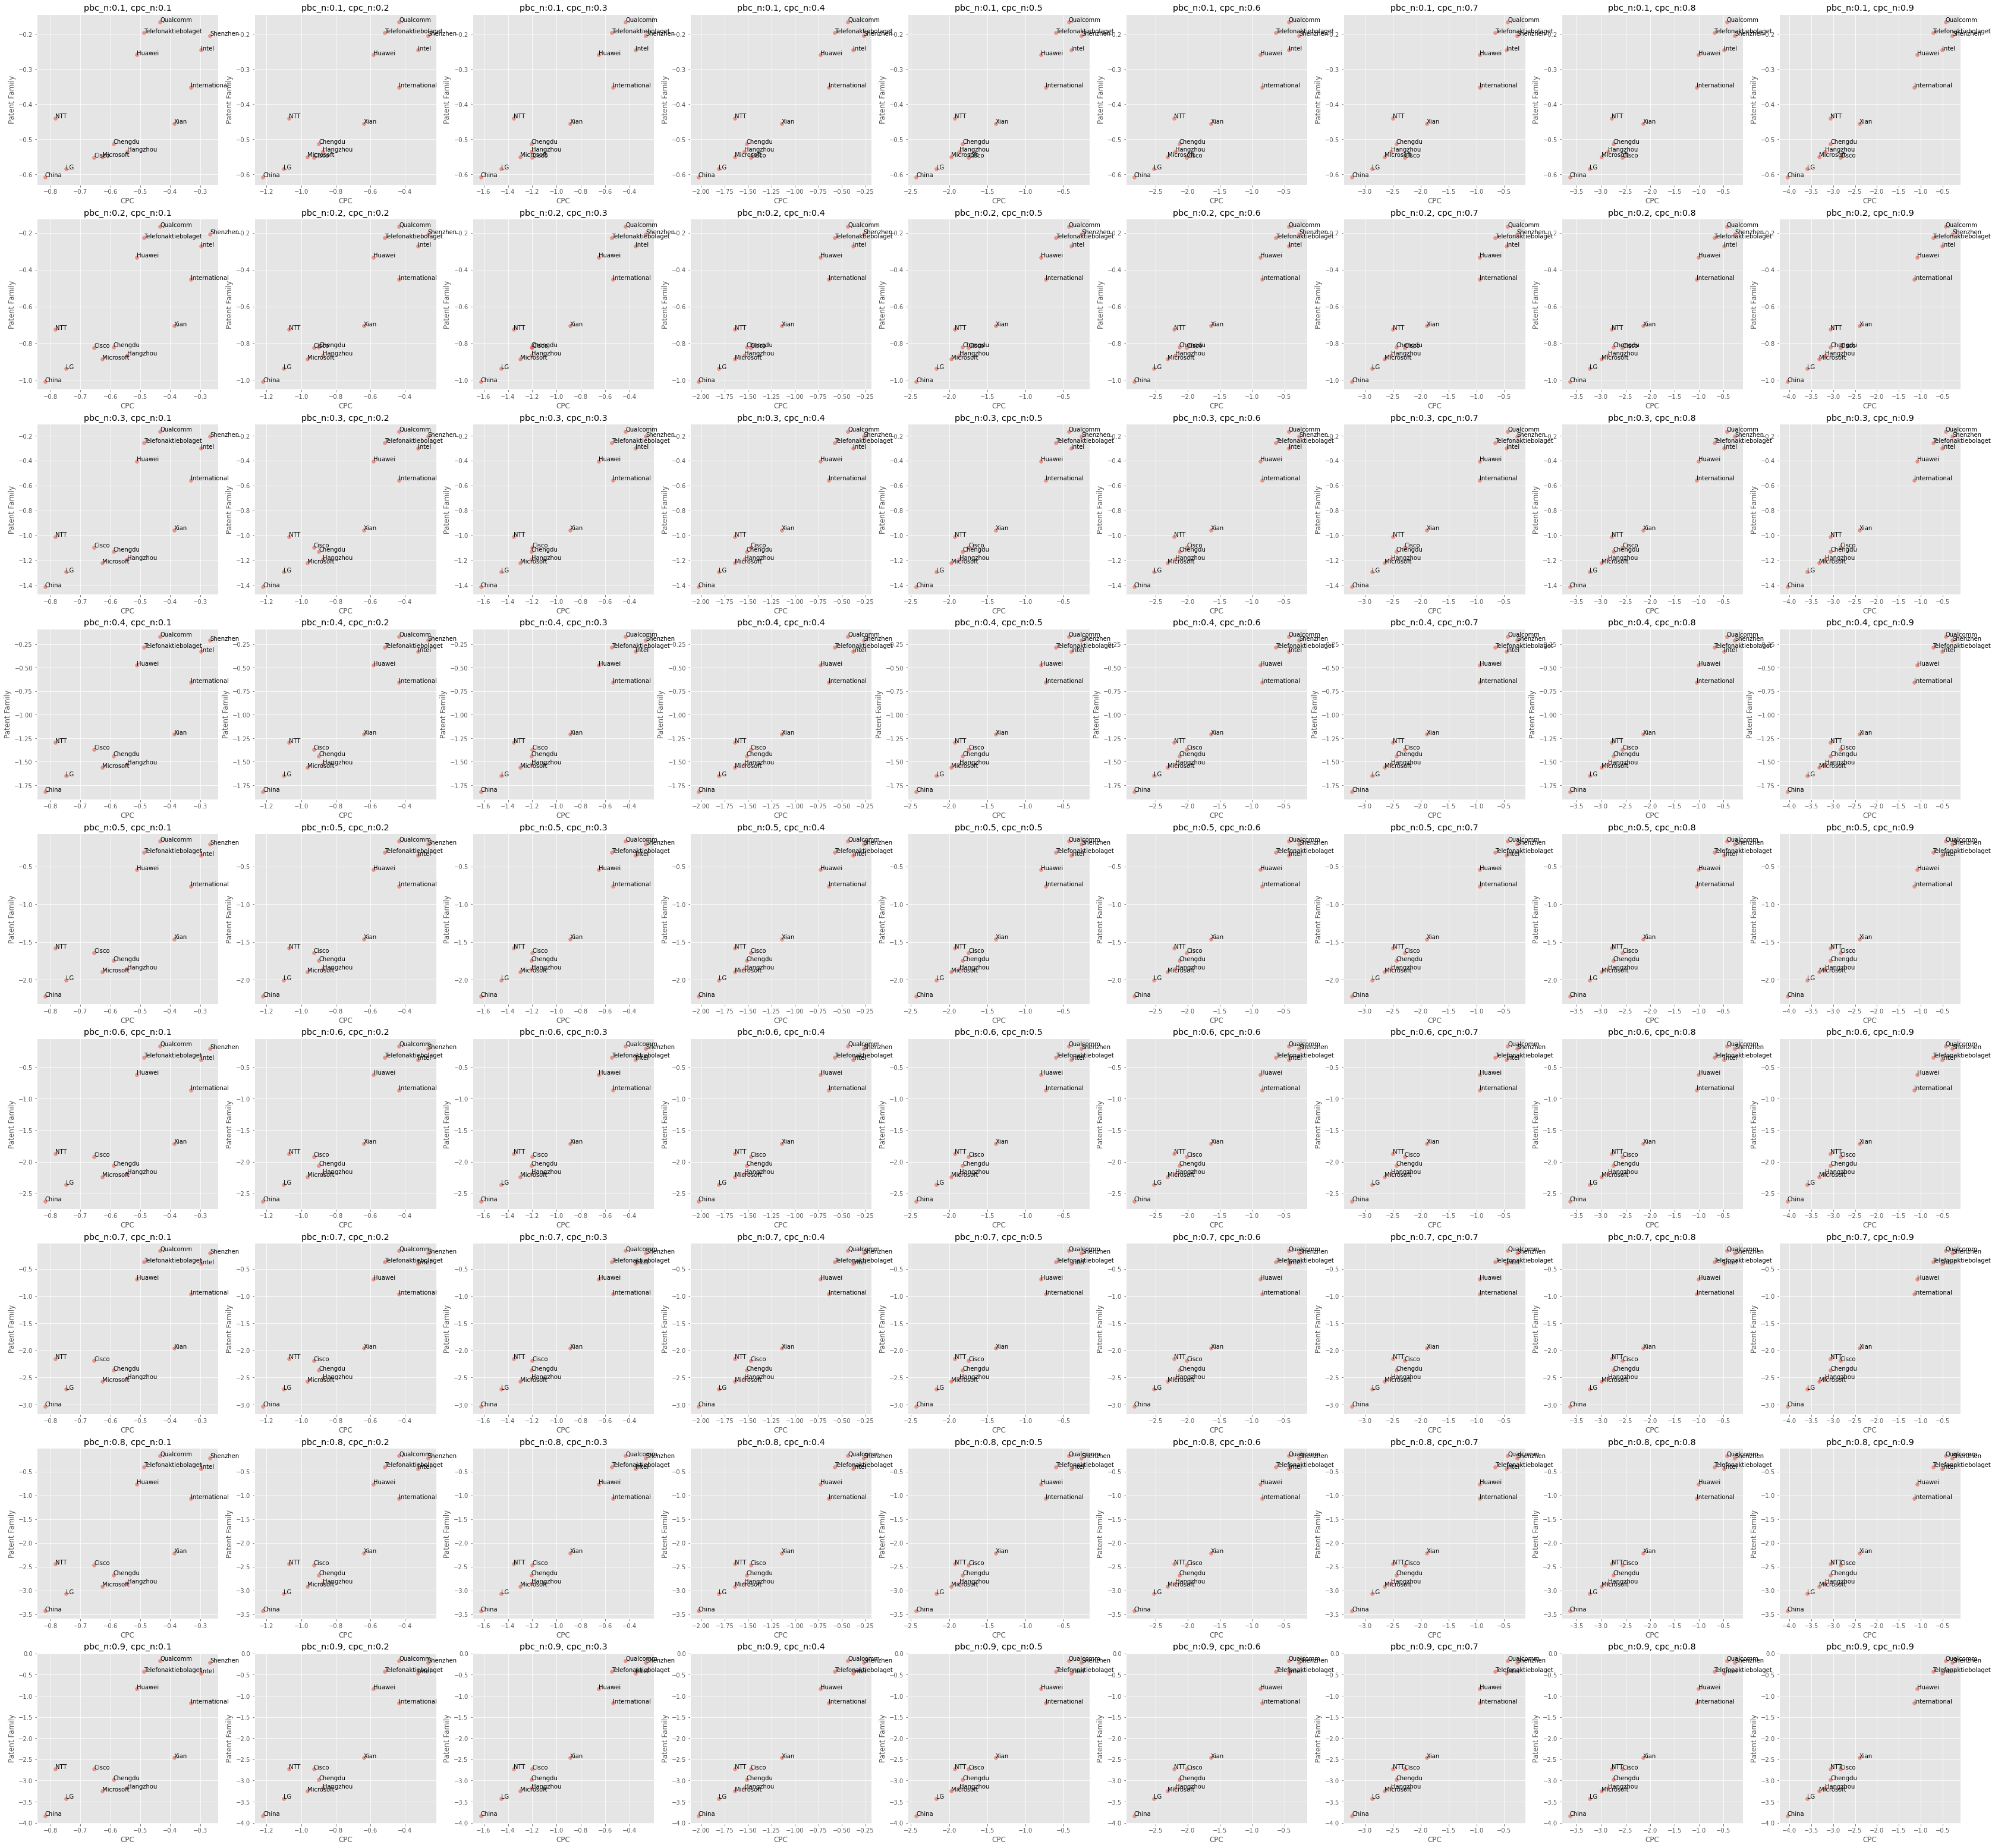

In [24]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2017_1.png'.format(pbc_n))

In [25]:
c_df

,cpc,country
company,,
Qualcomm Inc,0.434965,0.166484
Shenzhen Shenglu IoT Communication Technology Co Ltd,0.273051,0.210761
Intel Corp,0.513336,0.462053
Telefonaktiebolaget LM Ericsson AB,0.720792,0.430483
Huawei Technologies Co Ltd,1.084807,0.832133
International Business Machines Corp,1.147905,1.167672
Xian Irain IoT Technology Service Co Ltd,2.396245,2.464143
Cisco Technology Inc,2.836721,2.734003
NTT Docomo Inc,3.071196,2.726744


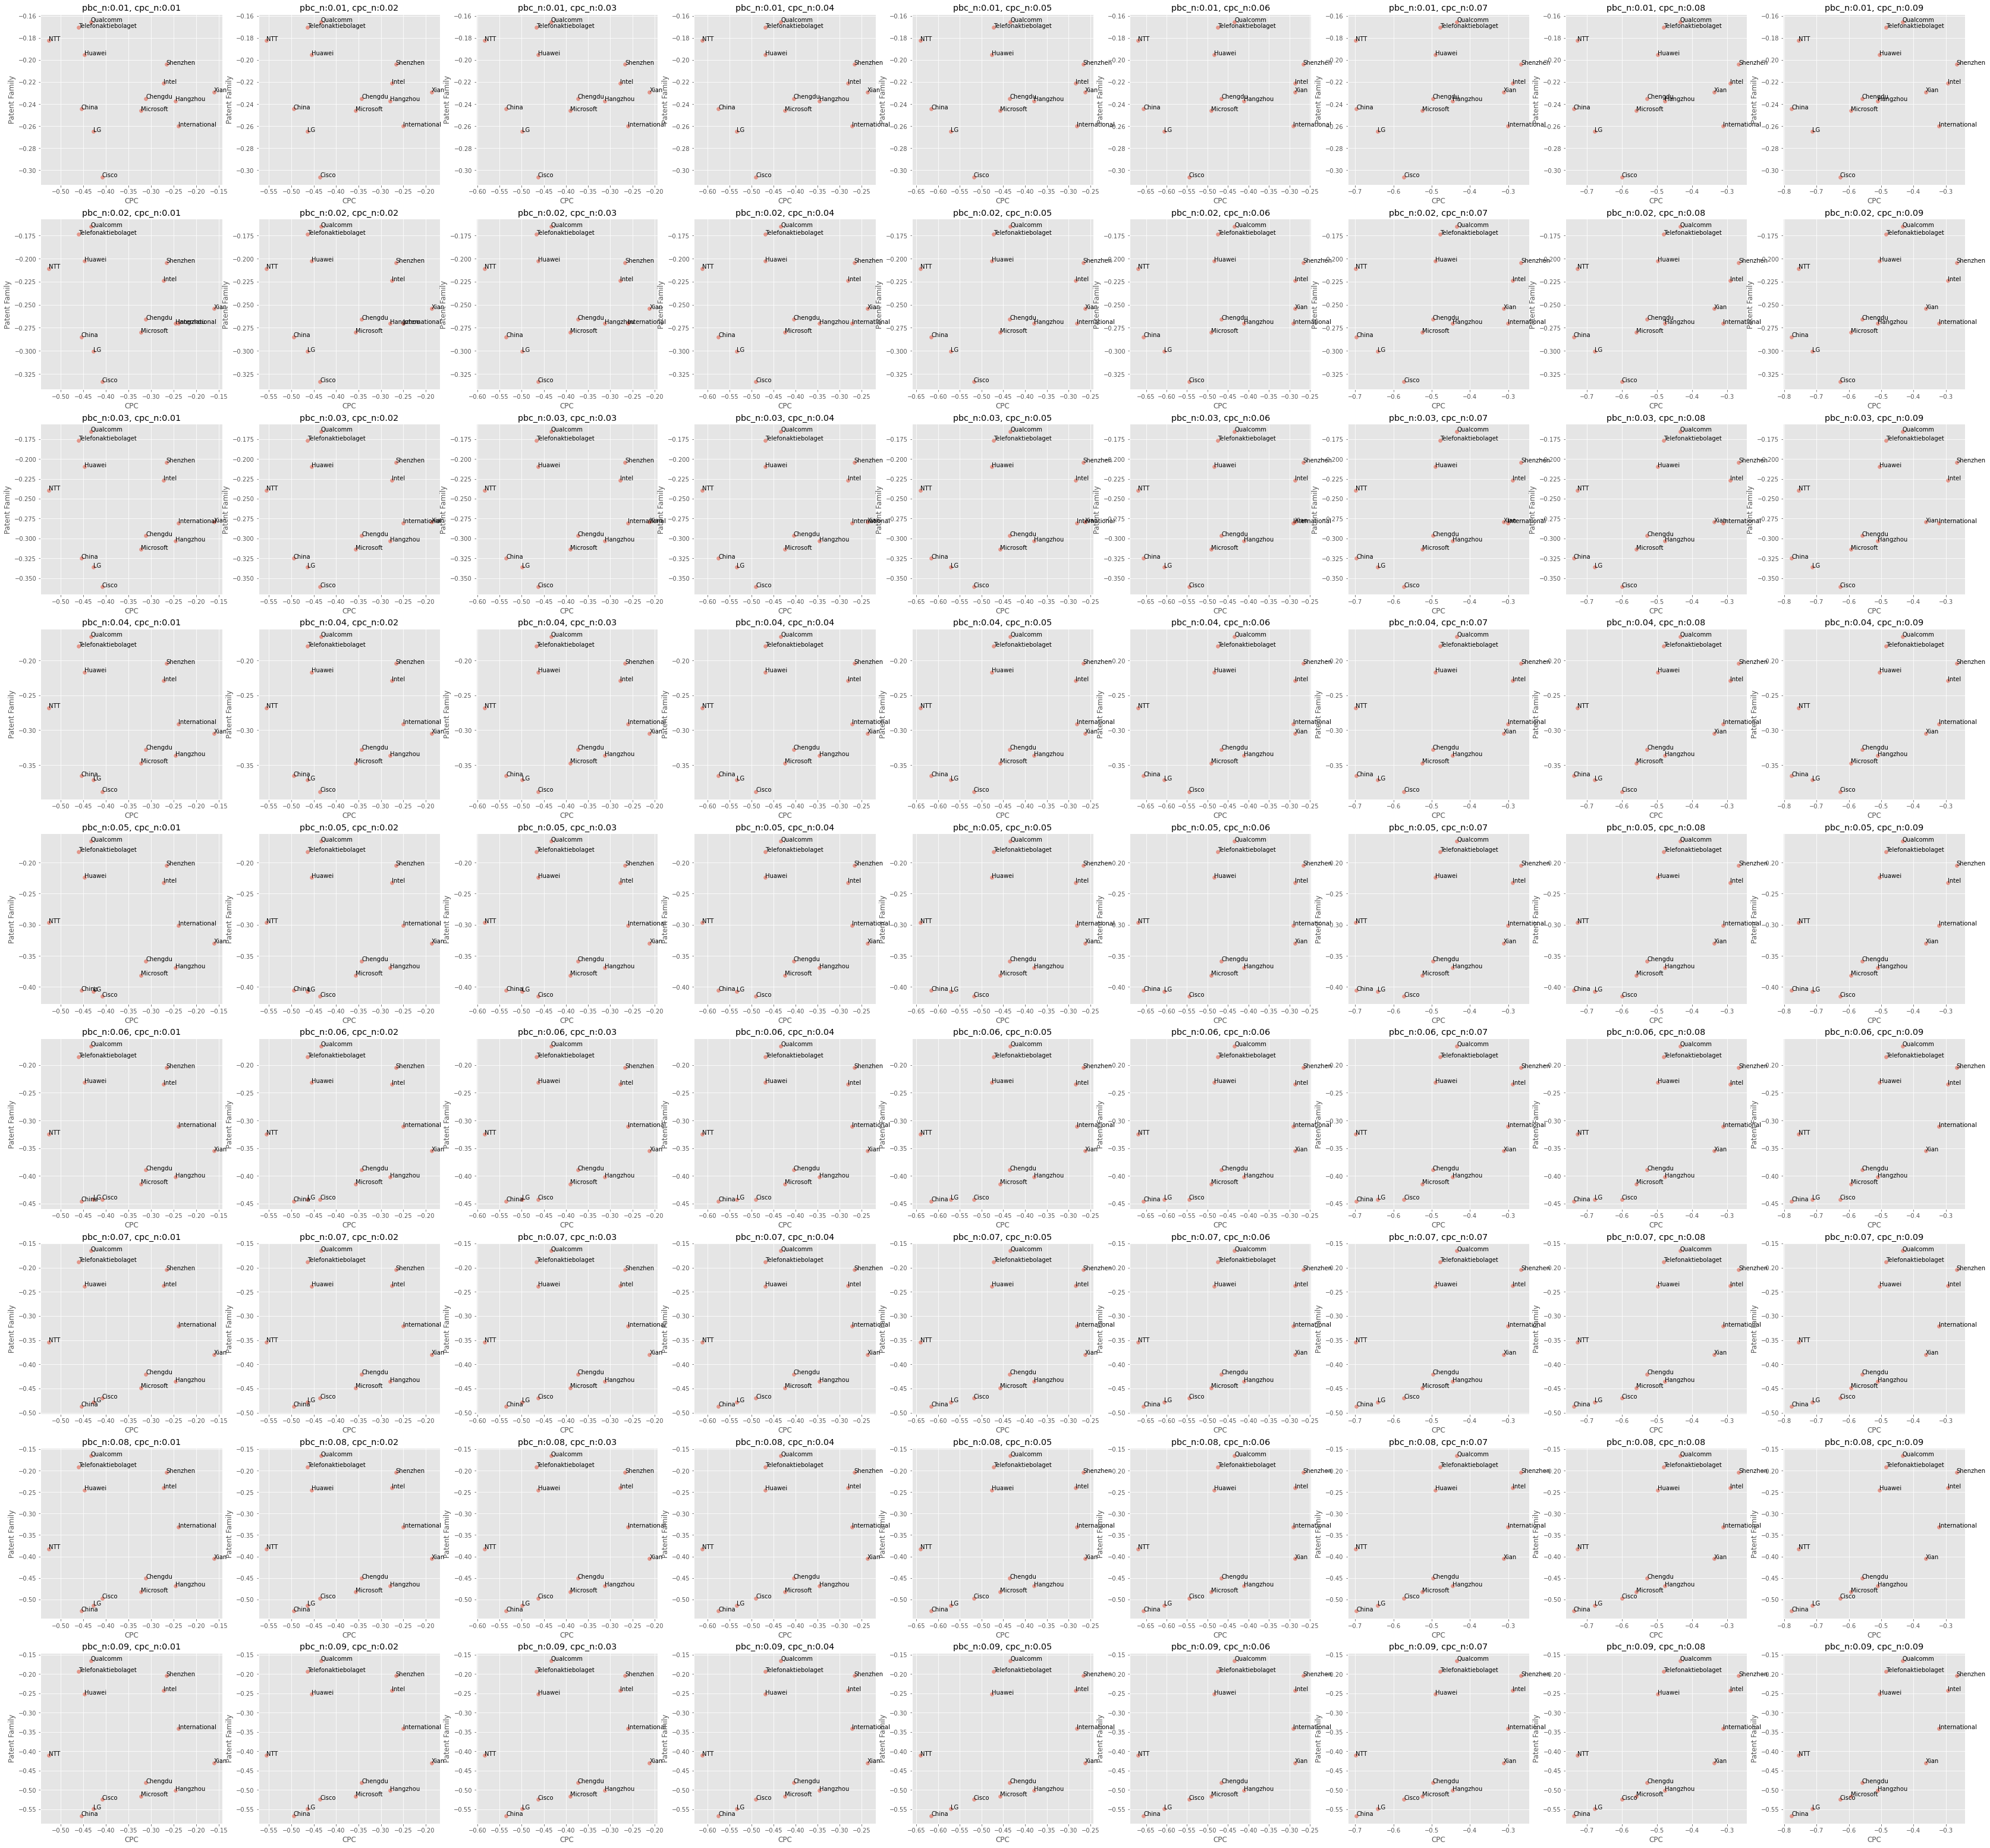

In [26]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2017_2.png'.format(pbc_n))

In [27]:
c_df

,cpc,country
company,,
Qualcomm Inc,0.434000,0.165519
Shenzhen Shenglu IoT Communication Technology Co Ltd,0.267032,0.204741
Intel Corp,0.294134,0.242852
Telefonaktiebolaget LM Ericsson AB,0.484368,0.194058
Huawei Technologies Co Ltd,0.505318,0.252644
International Business Machines Corp,0.322019,0.341786
Xian Irain IoT Technology Service Co Ltd,0.362182,0.430079
Cisco Technology Inc,0.627183,0.524465
NTT Docomo Inc,0.755472,0.411020


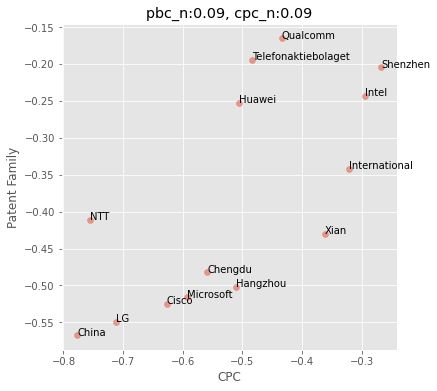

In [28]:
plt.figure(figsize=(6,6))
plt.style.use('ggplot')
c_df = scatter_plot(0.09,0.09)
c_df = c_df.drop("Samsung Electronics Co Ltd")

#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [29]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [30]:
competitor_ls

[1, 1, 1, 1, 1, 1, 3, 4, 4, 4, 3, 4, 4, 4]

In [31]:
c_df

,cpc,country
company,,
Qualcomm Inc,0.434000,0.165519
Shenzhen Shenglu IoT Communication Technology Co Ltd,0.267032,0.204741
Intel Corp,0.294134,0.242852
Telefonaktiebolaget LM Ericsson AB,0.484368,0.194058
Huawei Technologies Co Ltd,0.505318,0.252644
International Business Machines Corp,0.322019,0.341786
Xian Irain IoT Technology Service Co Ltd,0.362182,0.430079
Cisco Technology Inc,0.627183,0.524465
NTT Docomo Inc,0.755472,0.411020
